In [203]:
import os
import json
import pandas as pd
import seaborn as sns
sns.set_theme(style="whitegrid")


In [204]:
data_dir_path = r"C:\Users\ethan_haque\Desktop\tmp\books" 

In [205]:
# get paths to all json files recursively
json_files = []
for root, dirs, files in os.walk(data_dir_path):
    for file in files:
        if file.endswith(".json"):
             json_files.append(os.path.join(root, file))



In [206]:
print(len(json_files))
for file in json_files[:5]:
    print(file)

68
C:\Users\ethan_haque\Desktop\tmp\books\Emily\Batch 1 training set\Emily user 1433-2281 (8).json
C:\Users\ethan_haque\Desktop\tmp\books\Emily\Batch 10\Emily user 9-2962.json
C:\Users\ethan_haque\Desktop\tmp\books\Emily\Batch 23\Emily user 50-2995.json
C:\Users\ethan_haque\Desktop\tmp\books\Emily\Batch 24\Emily user 9-2962.json
C:\Users\ethan_haque\Desktop\tmp\books\Emily\Batch 25\Emily user 9-2962.json


In [207]:
def get_ra_and_batch_from_path(json_file_path):
    directory, filename = os.path.split(json_file_path)
    batch = directory.split("\\")[-1]
    ra = directory.split("\\")[-2]
    return ra, batch

In [208]:
# find directories without any directories in them that do not have json files
# these are errors
error_dirs = []
for root, dirs, files in os.walk(data_dir_path):
    if len(dirs) == 0:
        if len([file for file in files if file.endswith(".json")]) == 0:
            error_dirs.append(root)

In [209]:
error_dirs

['C:\\Users\\ethan_haque\\Desktop\\tmp\\books\\Michelle\\Batch 1 training set']

In [210]:
def convert_vgg_via_json_to_csv(json_file_path):
    data = read_json_data(json_file_path)
    ra, batch = get_ra_and_batch_from_path(json_file_path)
    rows = process_annotations(data, ra, batch)
    return rows

def read_json_data(json_file_path):
    with open(json_file_path, "r", encoding="utf-8") as f:
        data = json.load(f)
    return list(data["_via_img_metadata"].items())

def get_row_data_from_annotation(image_id, annotation, identifiable_catories, diversity_categories, ra, batch):
    row = {
        "image_id": image_id,
        "filename": annotation.get("filename", ""),
        "title": annotation.get("file_attributes", {}).get("title", ""),
        "google": annotation.get("file_attributes", {}).get("google", ""),
        "ra": ra,
        "batch": batch,
        "errors": []
    }

    identifiable_coding = annotation.get("file_attributes", {}).get("identifiable", "")
    if identifiable_coding != "" and identifiable_coding not in set(identifiable_catories.keys()):
        raise ValueError(f"Unrecognized identifiable coding: {identifiable_coding} for image {image_id}")
    for category, value in identifiable_catories.items():
        row[value] = category == identifiable_coding

    diversity_coding = annotation.get("file_attributes", {}).get("diversity", {})
    if diversity_coding != {}:
        for coded_category in diversity_coding:
            if coded_category not in set(diversity_categories.keys()):
                raise ValueError(f"Unrecognized diversity coding: {coded_category} for image {image_id}")
    for category, value in diversity_categories.items():
        row[value] = diversity_coding.get(category, False) or row.get(value, False) 

    if not identifiable_coding:
        row["errors"].append("Exactly one identifiable selection required.")
    if not diversity_coding and identifiable_coding and identifiable_coding != "no" and identifiable_coding != "different language":
        row["errors"].append("At least one diversity selection required.")
    if row["google"] and not row["title"]:
        row["errors"].append("Title required if Google link is present.")

    row["errors"] = "; ".join(row["errors"])

    return row

def process_annotations(data, ra, batch):
    identifiable_catories = {
        "yes": "identifiable_yes",
        "no": "identifiable_no",
        "with info sidebar": "identifiable_with_info_sidebar",
        "with detective work": "identifiable_with_detective_work",
        "different language": "identifiable_different_language",
    }

    diversity_categories = {
        "none": "diversity_none",
        "bipoc": "diversity_bipoc",
        "woman": "diversity_noncisman",
        "non-cis man": "diversity_noncisman",
        "lgbt": "diversity_lgbq",
        "lgbq": "diversity_lgbq",
        "non-christian": "diversity_non_christian",
        "disability": "diversity_disability",
        "other": "diversity_other",
        "ambiguous": "diversity_ambiguous"
    }

    rows = []
    for image_id, annotation in data:
        row = get_row_data_from_annotation(image_id, annotation, identifiable_catories, diversity_categories, ra, batch)
        rows.append(row)
        
    return rows


In [211]:
all_rows = []
for file in json_files:
    all_rows.extend(convert_vgg_via_json_to_csv(file))

In [212]:
df = pd.DataFrame(all_rows)

In [213]:
non_books_df = pd.read_csv(r"C:\Users\ethan_haque\Desktop\repos\bitmoji-project\books_parsing\Bitmoji Non-Books.csv")
df["TagID"] = df["filename"].str.split(".").str[0]
df = df[~df["TagID"].isin(non_books_df["TagID"])]

In [214]:
# get rid of duplicate rows that have been rebatched and keep the rebatched rows

# Identify filenames that are duplicated and at least one "rebatch" exists for those
filenames_to_filter = df[df["batch"].str.contains("rebatch")]["filename"].unique()

# Filter the DataFrame to keep rows with those filenames but only if they contain "rebatch"
rebatch_rows = df[(df["filename"].isin(filenames_to_filter)) & (df["batch"].str.contains("rebatch"))]

# Filter the DataFrame to get rows that either aren't in the filenames_to_filter list or have "rebatch"
df = pd.concat([df[~df["filename"].isin(filenames_to_filter)], rebatch_rows])


target_cols = ["filename"]
for col in df.columns:
    if col.startswith("diversity"):
        target_cols.append(col)

mask = df.duplicated(subset=target_cols, keep=False)
duplicated_rows = df[mask]
duplicated_rows_groups = duplicated_rows.groupby("filename")
# only keep the first row that has a title and a google link for each filename
duplicated_rows = duplicated_rows_groups.apply(lambda x: x[(x["title"] != "") & (x["google"] != "")].head(1))
duplicated_rows = duplicated_rows.reset_index(drop=True)


df = df[~mask]
df = pd.concat([df, duplicated_rows])
df = df.reset_index(drop=True)

In [215]:
# duplicate_rows = df[df["filename"].duplicated(keep=False)].sort_values(by="filename")
# duplicated_rows_groups = duplicate_rows.groupby("filename")

In [216]:
# turn into dataframe and write to csv
output_dir = "../books_report"
output_path = os.path.join(output_dir, "annotations.csv")
df.to_csv(output_path, index=False)

In [217]:
# create a csv of duplicate rows 
duplicate_rows = df[df["filename"].duplicated(keep=False)].sort_values(by="filename")
output_path = os.path.join(output_dir, "duplicate_rows.csv")
duplicate_rows.to_csv(output_path, index=False)

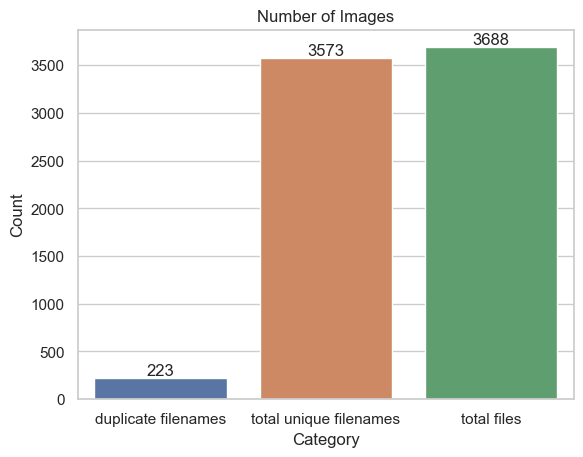

In [218]:
no_duplicates = df.drop_duplicates(subset=["filename"])

df["duplicate"] = df.duplicated(subset=["filename"], keep=False)
df["unique"] = ~df["duplicate"]
df["duplicate"] = df["duplicate"].astype(int)
df["unique"] = df["unique"].astype(int)


data = {
    "duplicate filenames": df["duplicate"].sum(),
    "total unique filenames": no_duplicates.shape[0],
    "total files": df["unique"].sum() + df["duplicate"].sum(),
}

ax = sns.barplot(x=list(data.keys()), y=list(data.values()))
ax.set_title("Number of Images")
ax.set_ylabel("Count")
ax.set_xlabel("Category")
ax.bar_label(ax.containers[0], fmt='%.0f', label_type='edge')

ax.figure.savefig(os.path.join(output_dir, "number_of_images.png"), bbox_inches="tight")

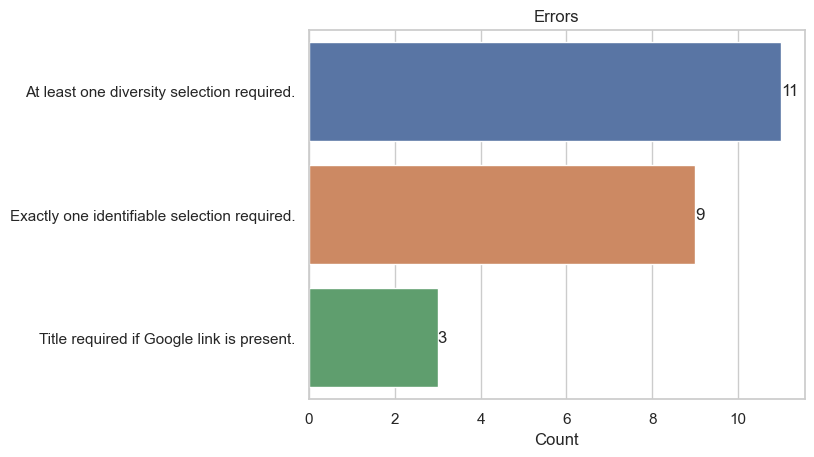

In [219]:
import os
import seaborn as sns

# Assuming df is already defined

data = df.groupby("errors").size().to_dict()
data_dictionary = {}
for key, value in data.items():
    if key:
        for error in key.split("; "):
            if error not in data_dictionary:
                data_dictionary[error] = 0
            data_dictionary[error] += value
data = data_dictionary  
data = {k: v for k, v in sorted(data.items(), key=lambda item: item[1], reverse=True)}

ax = sns.barplot(x=list(data.values()), y=list(data.keys()))
ax.set_title("Errors")
ax.set_xlabel("Count")
ax.bar_label(ax.containers[0], fmt='%.0f', label_type='edge')
ax.figure.savefig(os.path.join(output_dir, "number_of_errors.png"), bbox_inches="tight")


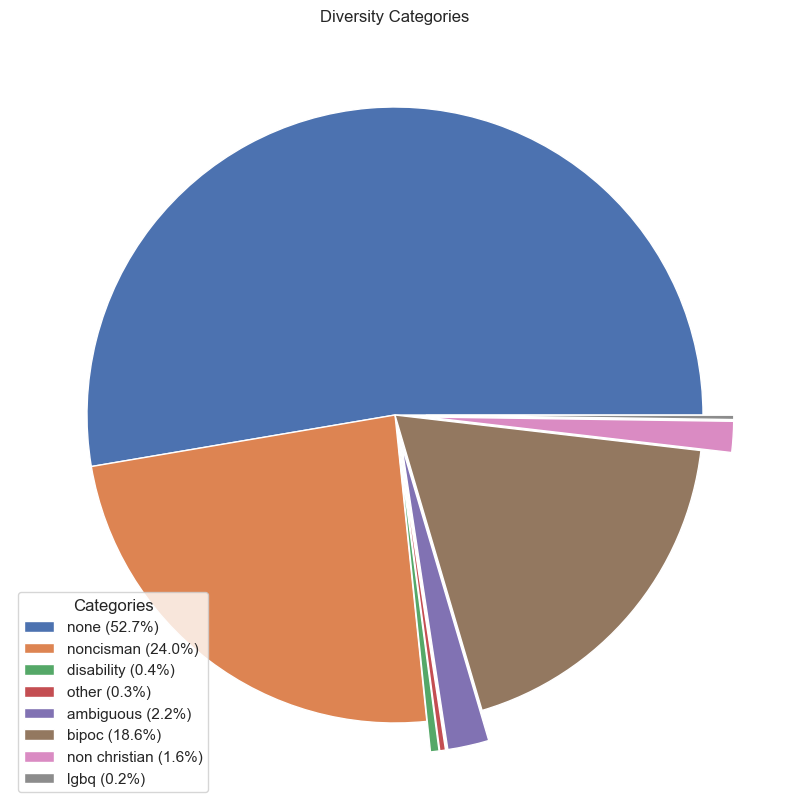

In [220]:
import matplotlib.pyplot as plt

# Create a pie chart of the different diversity categories
diversity_cols = [col for col in df.columns if col.startswith("diversity")]
data = df[diversity_cols].sum()
data = data.sample(frac=1)


# Determine slices that are smaller than a threshold, say 5%, and explode them
threshold = 0.05
explode = [0.1 if val/sum(data) < threshold else 0 for val in data]

ax = data.plot.pie(explode=explode, labels=None)  # No labels directly on pie
ax.set_title("Diversity Categories")
ax.set_ylabel("")
ax.legend(title="Categories", loc="best", labels=['%s (%.1f%%)' % (l[10:].replace("_", " "), s) for l, s in zip(data.index, 100*data/sum(data))])
ax.figure.set_size_inches(10, 10)
ax.figure.savefig(os.path.join(output_dir, "diversity_categories.png"), bbox_inches="tight")


In [221]:
# diversity_cols = [col for col in df.columns if col.startswith("diversity")]
# diversity_cols.remove('diversity_none')
# heatmap_data = df[diversity_cols]
# ax = sns.heatmap(heatmap_data.corr().round(3), annot=True, cmap="coolwarm")
# ax.set_title("Correlation Heatmap of Diversity Attributes")
# ax.figure.set_size_inches(12, 8)
# ax.figure.savefig(os.path.join(output_dir, "diversity_correlation_heatmap.png"), bbox_inches="tight")

In [222]:
# # create bar chart of the different identifiable methods
# identifiable_cols = [col for col in df.columns if col.startswith("identifiable")]
# data = df[identifiable_cols].sum().to_dict()
# data = {key.replace("identifiable_", "").replace("_", " "): value for key, value in data.items()}
# ax = sns.barplot(x=list(data.keys()), y=list(data.values()))
# ax.figure.set_size_inches(10, 6)
# ax.set_title("Identifiable Methods")
# ax.set_ylabel("Count")
# ax.set_xlabel("Category")
# ax.bar_label(ax.containers[0], fmt='%.0f', label_type='edge')
# ax.figure.savefig(os.path.join(output_dir, "identifiable_methods.png"), bbox_inches="tight")

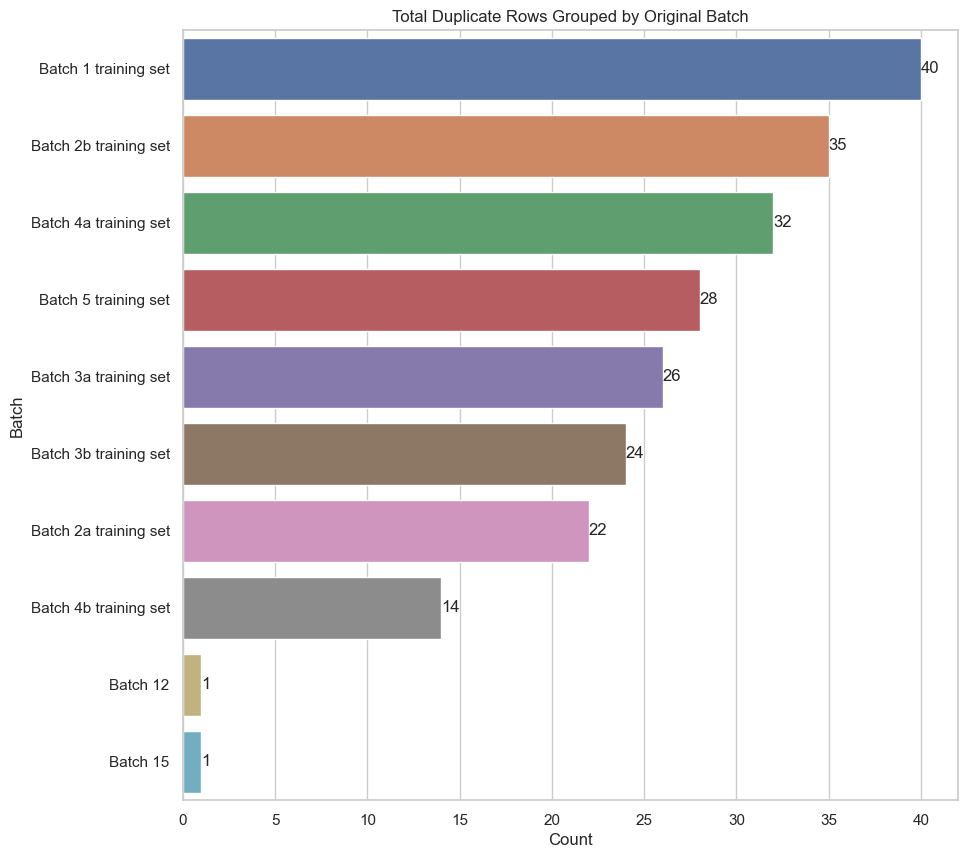

In [223]:
# create a bar chart of the duplicate images by batch
data = df[df["filename"].duplicated(keep=False)].groupby("batch").size().to_dict()
data = {k: v for k, v in sorted(data.items(), key=lambda item: item[1], reverse=True)}
ax = sns.barplot(x=list(data.values()), y=list(data.keys()))
ax.figure.set_size_inches(10, 10)
ax.set_title("Total Duplicate Rows Grouped by Original Batch")
ax.bar_label(ax.containers[0], fmt='%.0f', label_type='edge')
ax.set_xlabel("Count")
ax.set_ylabel("Batch")
ax.figure.savefig(os.path.join(output_dir, "duplicate_rows_by_batch.png"), bbox_inches="tight")
